In [11]:
library(tidyverse)
library(glmnet)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-13



In [12]:
load(file="data/GSE40279_r2.Rdata")
load(file="data/GSE41169_r2.Rdata")

In [52]:
# Age is stored in `characteristics_ch1` for training and `characteristics_ch1.6` for test in the metadata dataframes

# parse the strings and extract the age information
train.age  <- sapply(as.character(gse40279.meta$characteristics_ch1),
                     function(ch) as.numeric(unlist(strsplit(ch, ' '))[3]))
test.age  <- sapply(as.character(gse41169.meta$characteristics_ch1.6),
                     function(ch) as.numeric(unlist(strsplit(ch, ' '))[2]))

# remove names
names(train.age)  <- NULL
names(test.age)  <- NULL

In [54]:
# find common probes
train.probes  <- rownames(gse40279.data)
test.probes  <- rownames(gse41169.data)
common.probes  <- intersect(rownames(gse41169.data), rownames(gse40279.data))

# only select the common probes in training and test datasets
train.common  <- gse40279.data[common.probes,]
test.common  <- gse41169.data[common.probes,]

In [91]:
# number of common probes
length(common.probes)

[1] 118271

In [49]:
# summarize the ages in the training dataset
summary(train.age)
mean(train.age)
sd(train.age)
length(train.age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.00   54.00   65.00   64.04   75.00  101.00 

[1] 64.03506

[1] 14.73668

[1] 656

In [50]:
# summarize the ages in the test dataset
summary(test.age)
mean(test.age)
sd(test.age)
length(test.age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.00   24.50   29.00   31.57   36.00   65.00 

[1] 31.56842

[1] 10.28286

[1] 95

In [72]:
# inpute missing values based on means
imputeData  <- function(probeData) {
    probeData[is.na(probeData)]  <- mean(probeData, na.rm=T)
    return(probeData)
}

In [90]:
train.common.imputed  <- t(apply(train.common, 1, imputeData))
test.common.imputed  <- t(apply(test.common, 1, imputeData))

In [315]:
# Train glmnet for prediction
set.seed(5)
glmnet.Training.CV  <-  cv.glmnet(t(train.common.imputed), train.age, nfolds=10,alpha=0.5,family="gaussian")

# The definition of the lambda parameter:
lambda.glmnet.Training  <-  glmnet.Training.CV$lambda.1se 
print(lambda.glmnet.Training)

[1] 1.414358


In [316]:
# calculate the coefficients at the minimum lambda value
glmnet.coef  <- coef(glmnet.Training.CV, s=lambda.glmnet.Training)

In [317]:
# write out the coefficients
write.table(as.matrix(glmnet.coef), file='coefficients.csv', col.names = F, sep="\t")

In [318]:
# predict the age in the test set
pred.age.test <- predict(glmnet.Training.CV, newx = t(test.common.imputed), s = "lambda.1se")
pred.age.train <- predict(glmnet.Training.CV, newx = t(train.common.imputed), s = "lambda.1se")

In [319]:
# R^2 and correlation for training set
print(cor(pred.age.train, train.age)^2)
print(cor(pred.age.train, train.age))

# R^2 and correlation for training set
print(cor(pred.age.test, test.age)^2)
print(cor(pred.age.test, test.age))

       [,1]
1 0.9192373
       [,1]
1 0.9587687
       [,1]
1 0.9009715
       [,1]
1 0.9491952


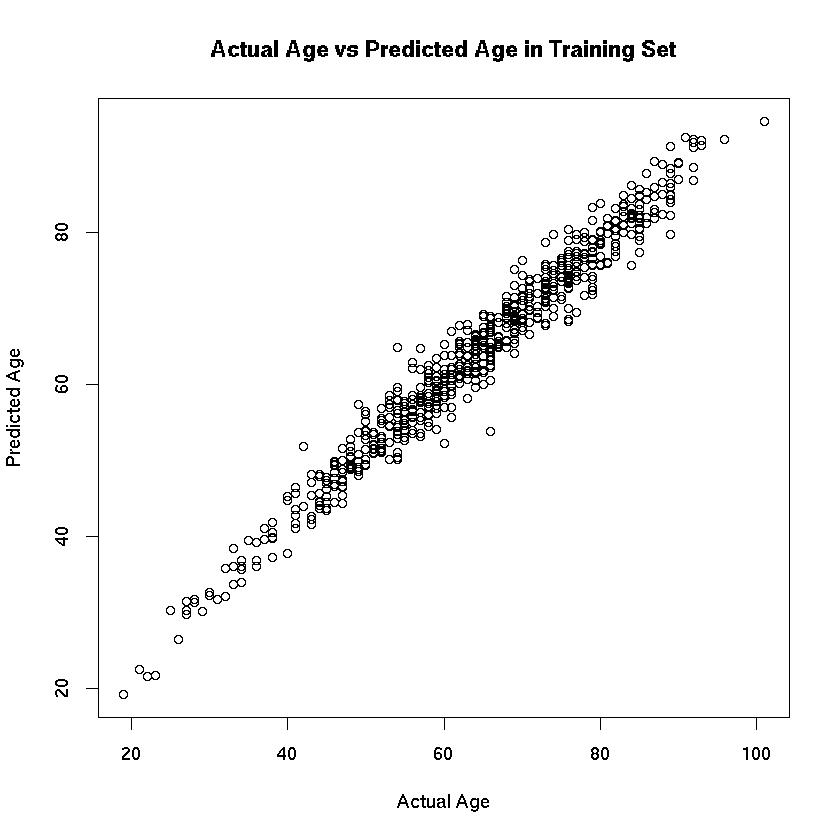

In [52]:
# plotting predicted age vs actual age in training set
plot(y=pred.age.train, x=train.age, ylab="Predicted Age", xlab="Actual Age", main="Actual Age vs Predicted Age in Training Set")

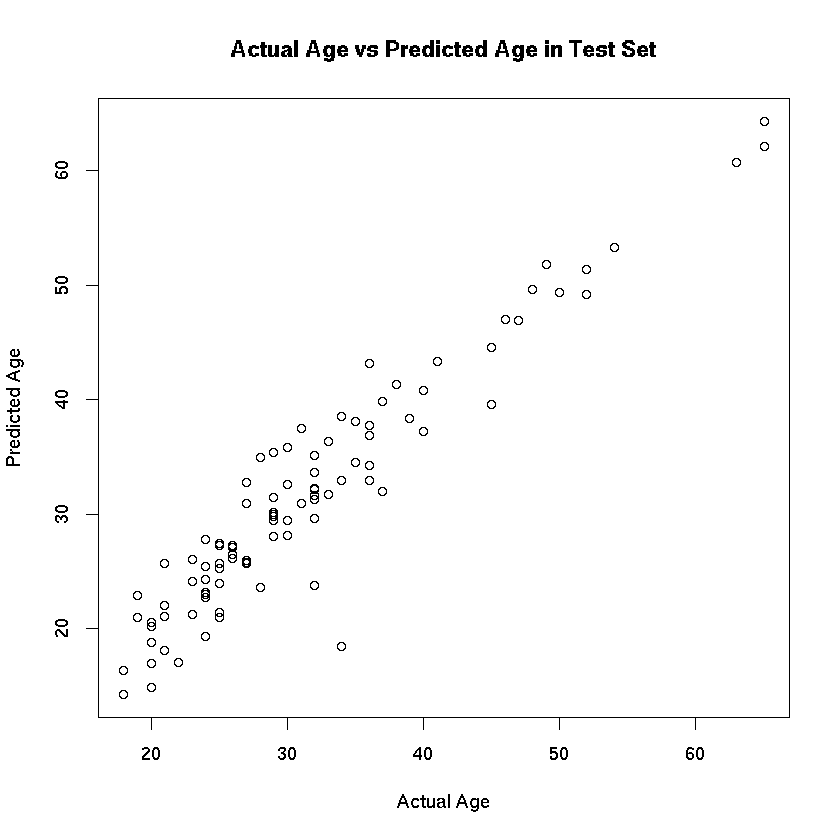

In [53]:
# plotting predicted age vs actual age in test set
plot(y=pred.age.test, x=test.age, ylab="Predicted Age", xlab="Actual Age", main="Actual Age vs Predicted Age in Test Set")

In [320]:
# Age accelerated
length(which(test.age > pred.age.test))

[1] 30

In [321]:
# Age decelerated
length(which(test.age < pred.age.test))

[1] 65

In [195]:
save.image()

In [322]:
# test if age acceleration and deceleration is different
# between genders in the training set
train.gender  <- gse40279.meta$characteristics_ch1.3
train.females  <- which(train.gender=="gender: F")
train.males  <- which(train.gender=="gender: M")
train.females.acc  <- length(which(train.age[train.females] > pred.age.train[train.females]))
train.females.dec  <- length(which(train.age[train.females] < pred.age.train[train.females]))
train.males.acc  <- length(which(train.age[train.males] > pred.age.train[train.males]))
train.males.dec  <- length(which(train.age[train.males] < pred.age.train[train.males]))

chisq.test(
    matrix(
        c(train.females.acc, train.males.acc, 
          train.females.dec, train.males.dec), 
        ncol=2), correct=F)

# again test for the test set
test.gender  <- gse41169.meta$characteristics_ch1
test.females  <- which(test.gender=="gender: Female")
test.males  <- which(test.gender=="gender: Male")
test.females.acc  <- length(which(test.age[test.females] > pred.age.test[test.females]))
test.females.dec  <- length(which(test.age[test.females] < pred.age.test[test.females]))
test.males.acc  <- length(which(test.age[test.males] > pred.age.test[test.males]))
test.males.dec  <- length(which(test.age[test.males] < pred.age.test[test.males]))

chisq.test(
    matrix(
        c(test.females.acc, test.males.acc, 
          test.females.dec, test.males.dec), 
        ncol=2), correct=F)


	Pearson's Chi-squared test

data:  matrix(c(train.females.acc, train.males.acc, train.females.dec,     train.males.dec), ncol = 2)
X-squared = 1.0866, df = 1, p-value = 0.2972



	Pearson's Chi-squared test

data:  matrix(c(test.females.acc, test.males.acc, test.females.dec,     test.males.dec), ncol = 2)
X-squared = 0.1662, df = 1, p-value = 0.6835


In [329]:
glmnet.coef.sorted  <- as.matrix(glmnet.coef)
glmnet.coef.sorted  <- glmnet.coef.sorted[order(-abs(glmnet.coef.sorted)), , drop=F]
#filter out 0
glmnet.coef.sorted  <- glmnet.coef.sorted[glmnet.coef.sorted != 0, , drop=F]

#convert to dataframe
glmnet.coef.sorted  <- as.data.frame(glmnet.coef.sorted)

In [41]:
source("https://bioconductor.org/biocLite.R")
biocLite("IlluminaHumanMethylation450kanno.ilmn12.hg19")

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.1 (2017-06-30).
Installing package(s) ‘IlluminaHumanMethylation450kanno.ilmn12.hg19’
also installing the dependencies ‘registry’, ‘rngtools’, ‘pkgmaker’, ‘xtable’, ‘locfit’, ‘doRNG’, ‘multtest’, ‘base64’, ‘annotate’, ‘bumphunter’, ‘beanplot’, ‘nor1mix’, ‘siggenes’, ‘limma’, ‘preprocessCore’, ‘illuminaio’, ‘mclust’, ‘genefilter’, ‘reshape’, ‘quadprog’, ‘data.table’, ‘GEOquery’, ‘minfi’

Warning message in install.packages(pkgs = doing, lib = lib, ...):
“installation of package ‘preprocessCore’ had non-zero exit status”Warning message in install.packages(pkgs = doing, lib = lib, ...):
“installation of package ‘minfi’ had non-zero exit status”Warning message in install.packages(pkgs = doing, lib = lib, ...):
“installation of package ‘IlluminaHumanMethylation450kanno.ilmn12.hg19’ had non-zero exit status”installation path not writeab

In [330]:
library(FDb.InfiniumMethylation.hg19)

In [331]:
hm450 <- get450k()
probeset  <- rownames(glmnet.coef.sorted)[2:length(rownames(glmnet.coef.sorted))]
probes <- hm450[probeset]

genes  <- getNearestTSS(probes)$nearestGeneSymbol

Fetching coordinates for hg19...


ERROR: Error: subscript contains invalid names


In [294]:
write.csv(genes, file='genes.csv', sep="\t")

Warning message in write.csv(genes, file = "genes.csv", sep = "\t"):
“attempt to set 'sep' ignored”

In [326]:
cor.matrix  <- cor(train.common.imputed[probeset,])
pca  <- prcomp(cor.matrix)

ERROR: Error in train.common.imputed[probeset, ]: subscript out of bounds


In [225]:
pca.summary  <- summary(pca)
ind <- which(pca.summary$importance["Cumulative Proportion",] > 0.9)
ind[1]

PC4 
  4

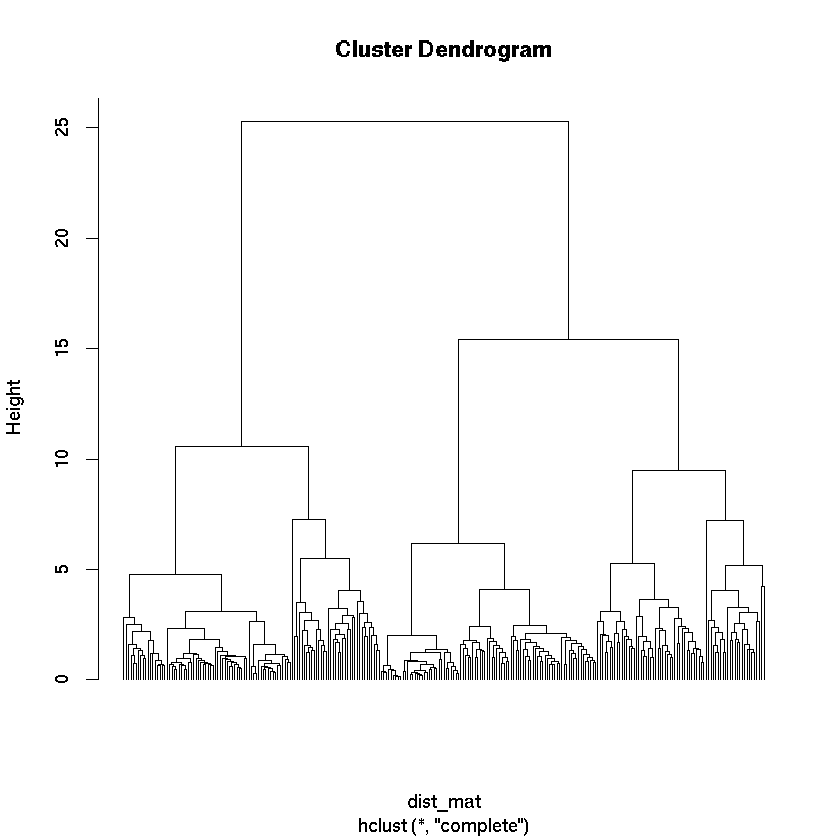

In [229]:
dist_mat <- dist(train.common.imputed[probeset,])
clustering <- hclust(dist_mat, method = "complete")
plot(clustering, labels = F, hang=-1)

In [280]:
cut  <- cutree(clustering, k=30)

In [281]:
probeset.top  <- cut[which(cut == cut[probeset[1:3]])]

In [288]:
probes <- hm450[names(probeset.top)]
genes.top  <- getNearestTSS(probes)$nearestGeneSymbol

In [291]:
write.csv(genes.top, file='top_genes.csv', sep="\t")

Warning message in write.csv(genes.top, file = "top_genes.csv", sep = "\t"):
“attempt to set 'sep' ignored”

In [332]:
str(probes)

Formal class 'GRanges' [package "GenomicRanges"] with 6 slots
  ..@ seqnames       :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. ..@ values         : Factor w/ 24 levels "chr1","chr2",..: 2 1 3 1 4 1 2 1 2 1 ...
  .. .. ..@ lengths        : int [1:188] 2 1 1 2 1 1 2 3 1 2 ...
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ ranges         :Formal class 'IRanges' [package "IRanges"] with 6 slots
  .. .. ..@ start          : int [1:267] 48668603 106015739 43424700 53080440 3431414 6190318 147558239 92952461 39187539 219827930 ...
  .. .. ..@ width          : int [1:267] 2 2 2 2 2 2 2 2 2 2 ...
  .. .. ..@ NAMES          : chr [1:267] "cg24516367" "cg06639320" "cg22176566" "cg03607117" ...
  .. .. ..@ elementType    : chr "integer"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  ..@ strand         :Formal class 'Rle' [package "S4Vectors"] with 4 slots
  .. .. ..@ values         : Factor w/ 3 levels "+","-","*": 3
  .. .. 

In [333]:
save.image()